In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd

from tobit import *

# Recovers true coefficients on artificial censored regression data

In [2]:
rs = np.random.RandomState(seed=10)
ns = 100
nf = 10
x, y_orig, coef = make_regression(n_samples=ns, n_features=nf, coef=True, noise=0.0, random_state=rs)
x = pd.DataFrame(x)
y = pd.Series(y_orig)

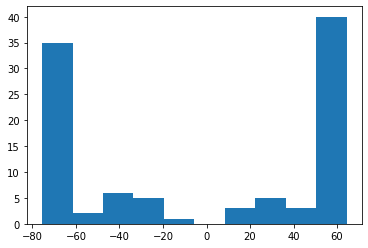

In [3]:
n_quantiles = 3 # two-thirds of the data is truncated
quantile = 100/float(n_quantiles)
lower = np.percentile(y, quantile)
upper = np.percentile(y, (n_quantiles - 1) * quantile)
left = y < lower
right = y > upper
y = y.clip(upper=upper, lower=lower)
hist = plt.hist(y)

In [4]:
tr = TobitModel(lower, upper)
result = tr.fit(x, y)

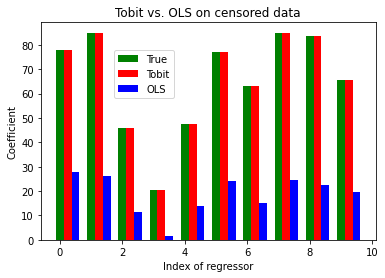

In [5]:
fig, ax = plt.subplots()
ind = np.arange(len(coef))
width = 0.25
rects1 = ax.bar(ind, coef, width, color='g', label='True')
rects2 = ax.bar(ind + width, tr.coef_, width, color='r', label='Tobit')
rects3 = ax.bar(ind + (2 * width), tr.ols_coef_, width, color='b', label='OLS')
plt.ylabel("Coefficient")
plt.xlabel("Index of regressor")
plt.title("Tobit vs. OLS on censored data")
leg = plt.legend(loc=(0.22, 0.65))

Note that the truncation values do not have to be the same for e.g. all left-censored observations, or all right-censored observations, as in this example. However, the model does assume that the errors will be normally-distributed.

# Comparison to R censReg package result on AER data

## Commands in R for Tobit analysis of Affairs data:
```
install.packages('censReg')
library(censReg)
install.packages('AER')
data('Affairs', package='AER')
write.table(Affairs, 'tobit_data.txt', quote=FALSE, row.names=FALSE)
estResult <- censReg( affairs ~ age + yearsmarried + religiousness +occupation + rating, data = Affairs)
summary(estResult)
```

## Python analysis of same data

In [6]:
data_file = 'tobit_data.txt'
df = pd.read_table(data_file, sep=' ')
df.loc[df.gender=='male', 'gender'] = 1
df.loc[df.gender=='female', 'gender'] = 0
df.loc[df.children=='yes', 'children'] = 1
df.loc[df.children=='no', 'children'] = 0
df = df.astype(float)
df.head()

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0.0,1.0,37.0,10.00,0.0,3.0,18.0,7.0,4.0
1,0.0,0.0,27.0,4.00,0.0,4.0,14.0,6.0,4.0
2,0.0,0.0,32.0,15.00,1.0,1.0,12.0,1.0,4.0
3,0.0,1.0,57.0,15.00,1.0,5.0,18.0,6.0,5.0
4,0.0,1.0,22.0,0.75,0.0,2.0,17.0,6.0,3.0


In [7]:
y = df.affairs
x = df.drop(['affairs', 'gender', 'education', 'children'], axis=1)

In [8]:
tr = TobitModel(0, math.inf)
tr = tr.fit(x, y)

In [9]:
tr.coef_

array([-0.17935226,  0.55417667, -1.68634756,  0.32615607, -2.28497301])

Note that the coefficients are identical to those obtained in the R analysis.